In [1]:
%matplotlib notebook

import jieba
import json
from collections import defaultdict

import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import LinearSVC

In [2]:
with open('pttgossip.json') as f:
    posts = json.load(f)


seg_posts = []
p_scores = []

for post in posts:
    words = defaultdict(int)
    content = post['content']
    if post['score'] != 0:
        for line in content.split('\n'):
            if line:
                for word in jieba.cut(line):
                    words[word] += 1
        if len(words) > 0:
            seg_posts.append(words)
            p_scores.append(1 if post['score'] > 0 else 0)
            
seg_comments = []
c_scores = []


for post in posts:
    for comment in post['comments']:
        words = defaultdict(int)
        line = comment['content'].strip()
        if line and comment['score'] != 0:
            for word in jieba.cut(line):
                words[word] += 1
            if len(words) > 0:
                seg_comments.append(words)
                c_scores.append(1 if comment['score'] > 0 else 0)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\zaq\AppData\Local\Temp\jieba.cache
Loading model cost 1.577 seconds.
Prefix dict has been built successfully.


In [3]:
p_dict_vec = DictVectorizer(sparse=False)
p_tfidf_tf = TfidfTransformer()
p_x = p_tfidf_tf.fit_transform(p_dict_vec.fit_transform(seg_posts))
p_svc = LinearSVC()
p_svc.fit(p_x, p_scores)

c_dict_vec = DictVectorizer(sparse=False)
c_tfidf_tf = TfidfTransformer()
c_x = c_tfidf_tf.fit_transform(c_dict_vec.fit_transform(seg_comments))
c_svc = LinearSVC()
c_svc.fit(c_x, c_scores)

LinearSVC()

In [4]:
p_df = pd.DataFrame(columns=['score', 'word'])
p_df['score'], p_df['word'] = p_svc.coef_[0], p_dict_vec.feature_names_

c_df = pd.DataFrame(columns=['score', 'word'])
c_df['score'], c_df['word'] = c_svc.coef_[0], c_dict_vec.feature_names_

<IPython.core.display.Javascript object>


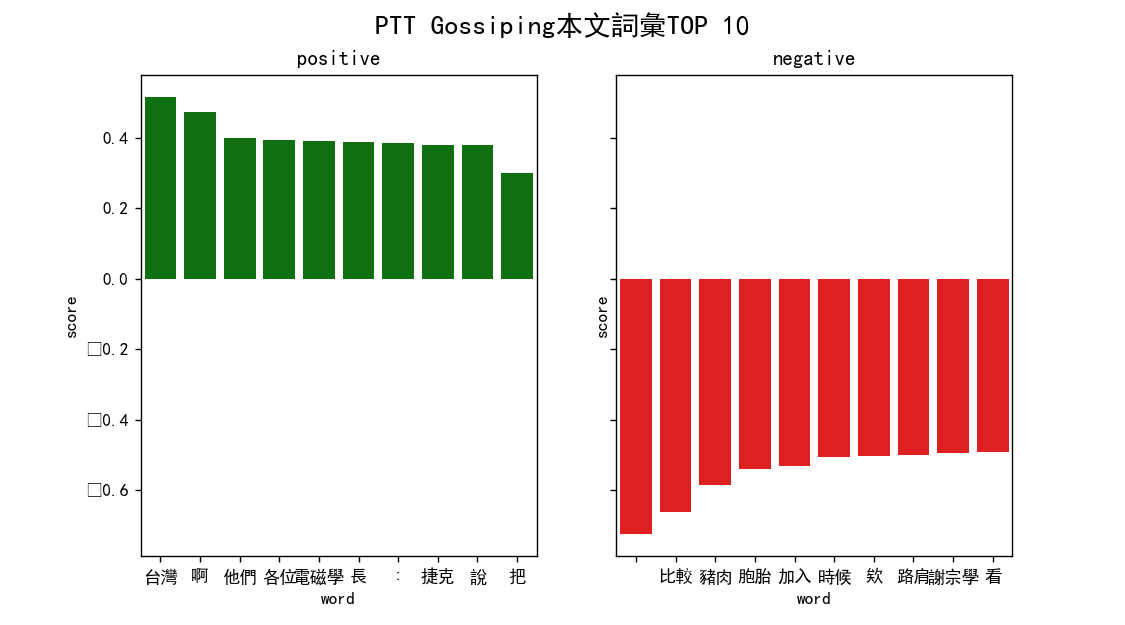

<IPython.core.display.Javascript object>


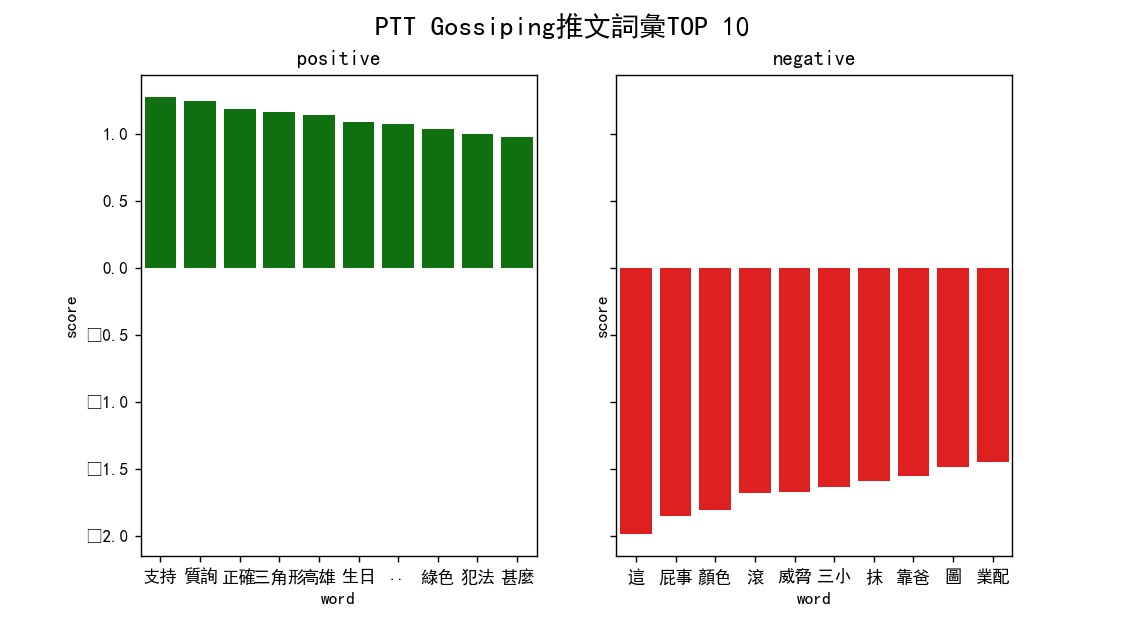

In [5]:
def show_chart(data, top_n, sup):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    p = sns.barplot(x='word', y='score', data=data.sort_values(by='score', ascending=False)[:top_n], color='green', ax=ax1)
    n = sns.barplot(x='word', y='score', data=data.sort_values(by='score')[:top_n], color='red', ax=ax2)
    p.set_title('positive')
    n.set_title('negative')
    fig.set_size_inches(9, 5)
    plt.suptitle('PTT Gossiping%s詞彙TOP %s' % (sup, top_n), fontsize=16)
    plt.rcParams['font.sans-serif'] = ['simhei']
    plt.show()

show_chart(p_df, 10, '本文')
show_chart(c_df, 10, '推文')